In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut


In [2]:
RHO_OBS = (1.401, 0.1401)

test = 'test6-s20-b0.48-e0.05-w90'
date = '09Feb22'

trace_S = pd.read_csv('/Users/mason/data/'+date+'/'+test+'/'+test+'_S.csv')
trace_EW = pd.read_csv('/Users/mason/data/'+date+'/'+test+'/'+test+'_EW.csv')

traces = {'S':trace_S, 'EW':trace_EW}

data = trace_S["rho"].values
###data_rho = trace_S["rho"].values

samples = data.reshape(-1,1)
###samples_rho = data_rho.copy().reshape(-1,1)

ess_mcmc = az.ess(samples.reshape(-1))
ess_mcmc


3058.9324837171716

In [3]:
def imp_sample(rho_array, rho_obs):
    '''
    Perform standard importance sampling from rho_tilde --> {e, omega}
    
    Args:
    rho_array [array]: sampled data for pseudo-density rho_tilde
    rho_obs [tuple]: values of the true stellar density and its uncertainty
    
    Output:
    weights [array]: importance sampling weights
    ecc [array]: random values drawn uniformly from 0 to 1, with array length = len(rho_array)
    omega [array]:random values drawn uniformly from -pi/2 to 3pi/2, with array length = len(rho_array)
    '''
    
    ecc = np.random.uniform(0., 1, len(rho_array))
    omega = np.random.uniform(-0.5*np.pi, 1.5*np.pi, len(rho_array))

    g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc ** 2)
    rho = rho_array / g ** 3

    log_weight = -0.5 * ((rho - rho_obs[0]) / rho_obs[1]) ** 2
    weight_rho = np.exp(log_weight - np.max(log_weight))
    weight_rho /= np.sum(weight_rho)

    weights = np.array(weight_rho/np.sum(weight_rho))
    
    return weights, ecc, omega


def get_bw(samples):
    '''
    Get an estimate of the KDE bandwidth of the input data.
    Bases estimate on a random sample of 10% of the data, for efficiency.
    
    Performs a grid search over a broad range then narrows the search range.
    
    Args:
    samples [array]: data to estimate the KDE bandwidth for
    
    Output:
    bw_best [float]: best-fit KDE bandwidth estimate
    '''
    
    N = len(samples.reshape(-1))

    X = np.random.choice(samples.reshape(-1), size=int(N*0.1), replace=False)
    X_interp = np.linspace(X.min()-np.std(X), X.max()+np.std(X), int(N*0.01))
    X_diff = np.diff(X_interp)[0]

    grid_input_broad = np.linspace((X.max()-X.min())/N, np.std(X), int(np.sqrt(N)))
    grid_broad = GridSearchCV(KernelDensity(), 
                                     param_grid={"bandwidth": grid_input_broad}, 
                                     cv=5)
    grid_broad.fit(X.reshape(-1,1))
    bw_broad = grid_broad.best_params_["bandwidth"]


    grid_input_narrow = np.linspace(bw_broad-X_diff, bw_broad+X_diff, int(np.sqrt(N)))
    grid_narrow = GridSearchCV(KernelDensity(), 
                                      param_grid={"bandwidth": grid_input_narrow}, 
                                      cv=5)
    grid_narrow.fit(X.reshape(-1,1))

    bw_best = grid_narrow.best_params_["bandwidth"]
    return bw_best


def get_new_samples(samples, bw, n_fin):
    '''
    Oversample new data based on the KDE of an input dataset
    
    Args:
    samples [array]: data to estimate the KDE bandwidth for
    bw [float]: best-fit KDE bandwidth estimate
    n_fin [int]: final number of samples desired in the output
    
    Output:
    samples_new [array]: array of 'n_fin' oversampled data points based on KDE of 'samples';
                         trims off any new samples beyond the range [samples.min, samples.max]
    '''
    
    n_oversample = int(n_fin*1.1)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(samples.reshape(-1,1))
    samples_new = kde.sample(n_oversample)

    samples_new = samples_new.reshape(-1)
    samples_new = samples_new[samples_new >= np.min(samples.reshape(-1))]
    samples_new = samples_new[samples_new <= np.max(samples.reshape(-1))]
    samples_new = np.random.choice(samples_new, n_fin)
    
    return samples_new

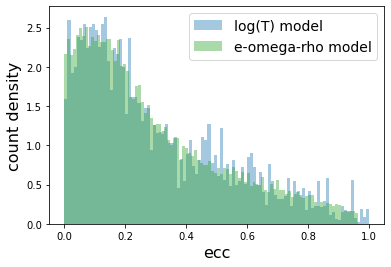

In [4]:
# Initial comparison of 'ecc' from log(T) model vs. e-omega-rho model

weights, ecc, omega = imp_sample(data, RHO_OBS)

plt.figure();
plt.hist(ecc, weights=weights, bins=100, density=True, alpha=0.4, label='log(T) model');
plt.hist(trace_EW['ecc'], bins=100, density=True, alpha=0.4, label='e-omega-rho model', color='C2');
plt.ylabel('count density', fontsize=16)
plt.xlabel('ecc', fontsize=16)
plt.legend(fontsize=14);
plt.show();

run_num = 1
ESS_mcmc = 3058.932484
ESS_imp = 1914.866848
N_kept: 1857


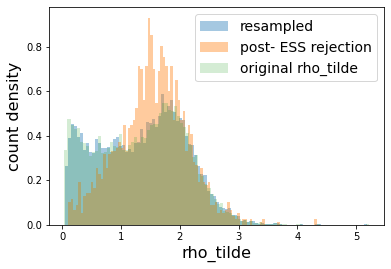

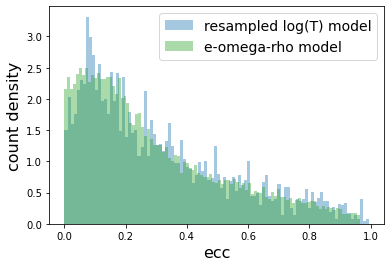

run_num = 2
ESS_mcmc = 3058.932484
ESS_imp = 2276.262407


/Users/mason/miniconda3/envs/mgp22/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan -3.95922277e+04 -8.65352484e+01
 -4.44248200e+01 -3.64549871e+01 -3.36086093e+01 -3.23273918e+01
 -3.16896325e+01 -3.13661665e+01 -3.12072678e+01 -3.11341893e+01
 -3.11046979e+01 -3.10972961e+01 -3.11018802e+01 -3.11140422e+01
 -3.11318866e+01 -3.11544855e+01 -3.11812617e+01 -3.12118055e+01
 -3.12458448e+01 -3.12832417e+01 -3.13239807e+01 -3.13681475e+01
 -3.14159047e+01 -3.14674679e+01 -3.15230832e+01 -3.15830065e+01
 -3.16474853e+01 -3.17167439e+01 -3.17909740e+01 -3.18703280e+01
 -3.19549179e+01 -3.20448159e+01 -3.21400575e+01]
  warnings.warn(


N_kept: 2224


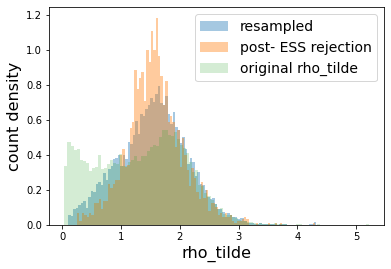

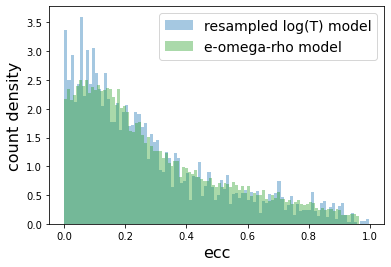

run_num = 3
ESS_mcmc = 3058.932484
ESS_imp = 2341.637298
N_kept: 2313


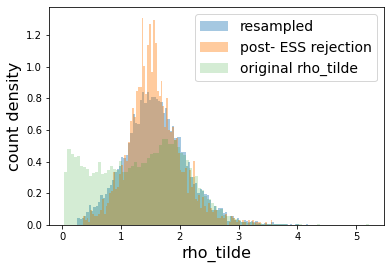

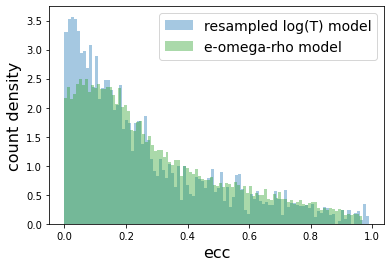

run_num = 4
ESS_mcmc = 3058.932484
ESS_imp = 2458.818470
N_kept: 2407


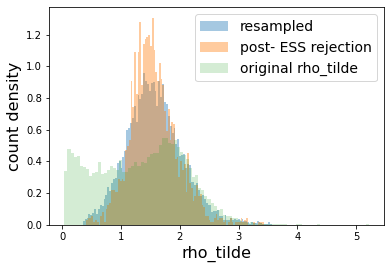

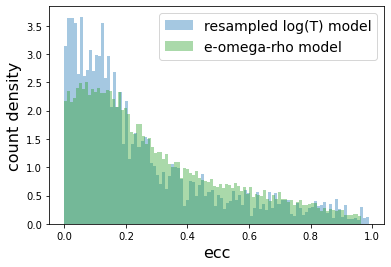

run_num = 5
ESS_mcmc = 3058.932484
ESS_imp = 2508.885278
N_kept: 2463


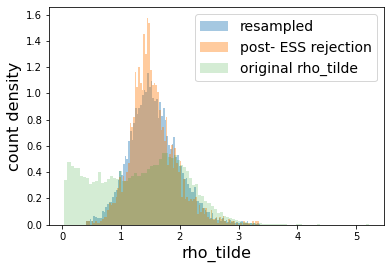

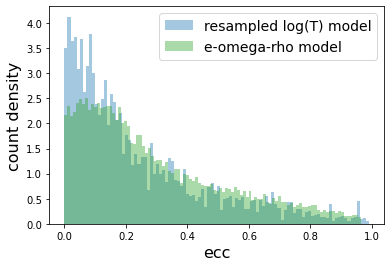

run_num = 6
ESS_mcmc = 3058.932484
ESS_imp = 2664.484175


/Users/mason/miniconda3/envs/mgp22/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [          nan           nan           nan           nan           nan
           nan           nan           nan -347.58674085  -65.98245381
  -37.68949309  -29.51245368  -26.03877393  -24.19372176  -23.0681973
  -22.32343139  -21.80672825  -21.43918344  -21.17619349  -20.99010095
  -20.86193264  -20.77760687  -20.72625127  -20.69940575  -20.69055087
  -20.69474859  -20.70833339  -20.7286446   -20.75380105  -20.78251765
  -20.81395935  -20.84762661  -20.88326586  -20.92079959  -20.96027204
  -21.0018072   -21.04557682  -21.09177663  -21.14060918  -21.192272
  -21.24694984  -21.30481015  -21.36600073  -21.43064904  -21.49886251
  -21.57072955  -21.64632081  -21.72569071  -21.80887888]
  warnings.warn(


N_kept: 2627


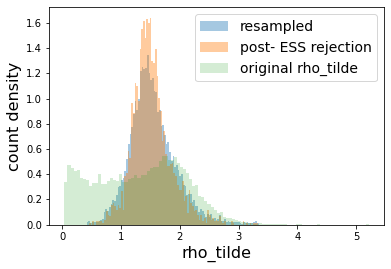

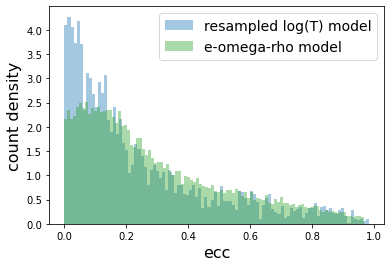

run_num = 7
ESS_mcmc = 3058.932484
ESS_imp = 2682.477590


/Users/mason/miniconda3/envs/mgp22/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan             nan
 -2.03262082e+04 -3.35226875e+02 -1.07171454e+02 -5.87655240e+01
 -4.08159060e+01 -3.22526362e+01 -2.75584279e+01 -2.47372524e+01
 -2.29225972e+01 -2.16923527e+01 -2.08247020e+01 -2.01959295e+01
 -1.97326514e+01 -1.93883634e+01 -1.91317578e+01 -1.89408059e+01
 -1.87996220e+01 -1.86966502e+01 -1.86234932e+01 -1.85740806e+01
 -1.85440453e+01 -1.85302485e+01 -1.85304224e+01 -1.85429051e+01
 -1.85664513e+01 -1.86000980e+01 -1.86430742e+01 -1.86947403e+01
 -1.87545493e+01 -1.88220226e+01 -1.88967353e+01 -1.89783071e+01
 -1.90663972e+01 -1.91607001e+01 -1.92609435e+01 -1.93668852e+01
 -1.94783104e+01 -1.95950290e+01 -1.97168725e+01 -1.98436907e+01
 -1.99753481e+01 -2.01117213e+01 -2.02526955e+01 -2.03981618e+01
 -2.05480150e+01 -2.07021513e+01 -2.08604669e+01]
  warni

N_kept: 2651


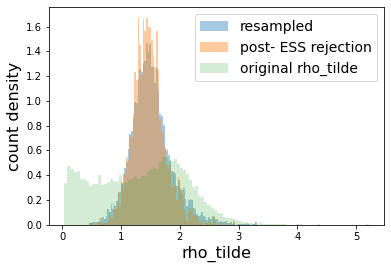

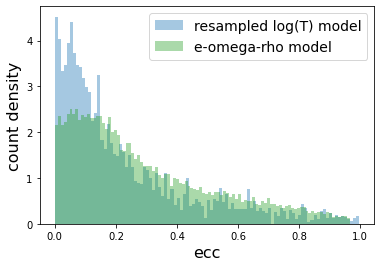

run_num = 8
ESS_mcmc = 3058.932484
ESS_imp = 2770.290857
N_kept: 2730


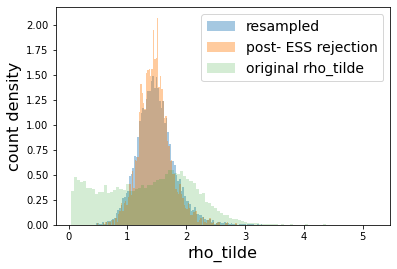

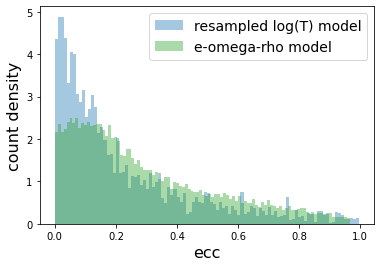

run_num = 9
ESS_mcmc = 3058.932484
ESS_imp = 2784.366107
N_kept: 2733


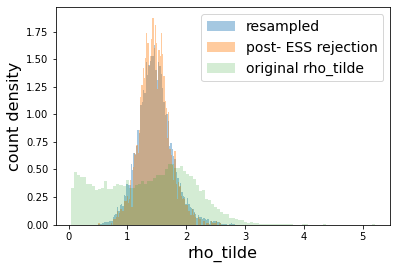

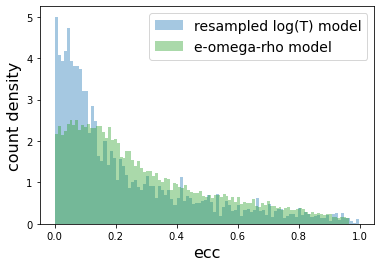

run_num = 10
ESS_mcmc = 3058.932484
ESS_imp = 2894.864106
N_kept: 2870


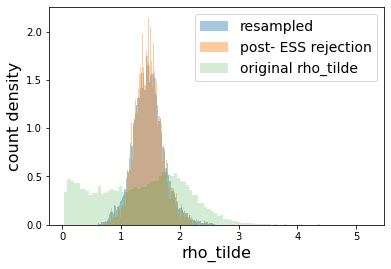

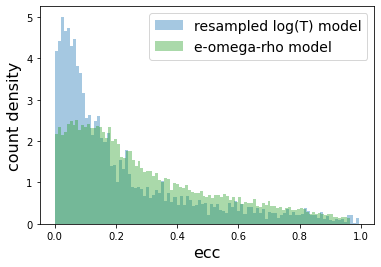

run_num = 11
ESS_mcmc = 3058.932484
ESS_imp = 2871.987584
N_kept: 2813


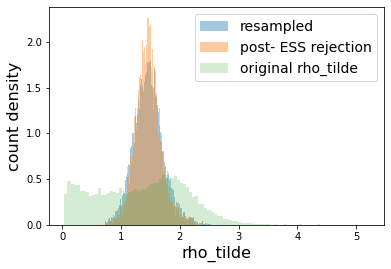

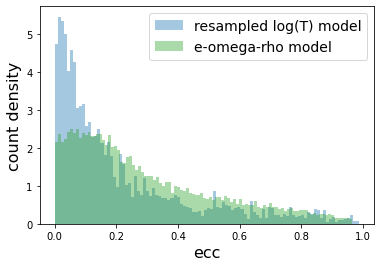

run_num = 12
ESS_mcmc = 3058.932484
ESS_imp = 2970.698079
N_kept: 2943


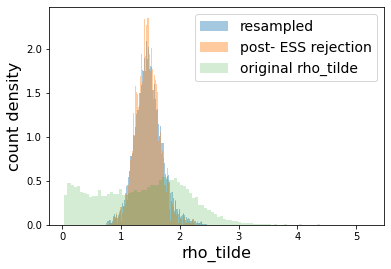

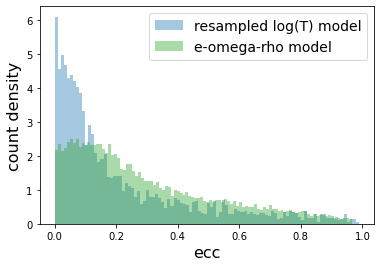

run_num = 13
ESS_mcmc = 3058.932484
ESS_imp = 2980.769098
N_kept: 2941


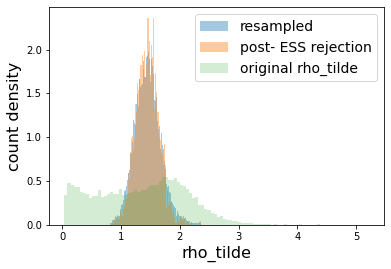

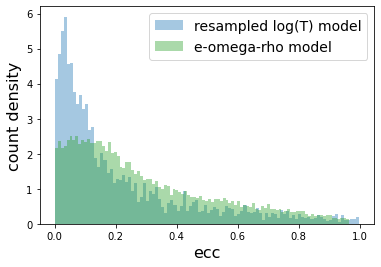

run_num = 14
ESS_mcmc = 3058.932484
ESS_imp = 2922.472653
N_kept: 2895


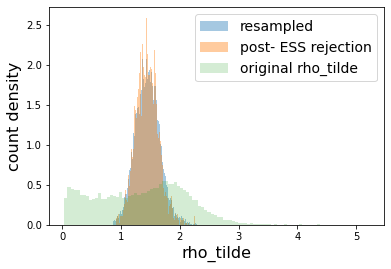

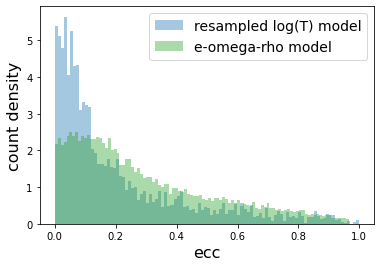

run_num = 15
ESS_mcmc = 3058.932484
ESS_imp = 2941.251118
N_kept: 2908


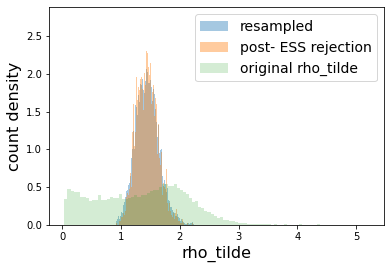

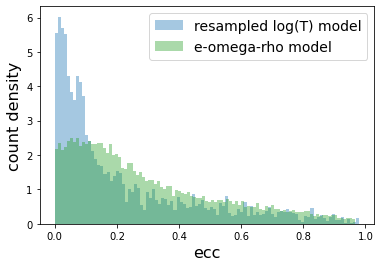

run_num = 16
ESS_mcmc = 3058.932484
ESS_imp = 2953.670215


/Users/mason/miniconda3/envs/mgp22/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [           nan            nan            nan            nan
            nan            nan            nan -1184.96927894
   -57.32659352    -4.20699627     8.42198321    13.00234618
    15.04967551    16.10323305    16.69984956    17.06403652
    17.30256079    17.46917511    17.59157165    17.68445442
    17.75602376    17.81107497    17.85250054    17.88210948
    17.90113673    17.91056924    17.91133834    17.90441221
    17.89081983    17.87163396    17.84793433    17.820766
    17.79110173    17.75981282    17.72764981    17.69523254
    17.66304832    17.63145629    17.6006964     17.57090148
    17.542111      17.51428569    17.48732199    17.46106601
    17.43532632    17.40988547    17.38451006    17.35895925
    17.33299188    17.30637211    17.2788738     17.25028384
    17.22040439]
  warnings.warn(


N_kept: 2926


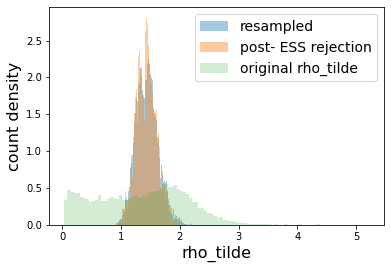

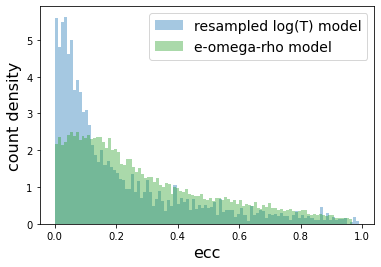

run_num = 17
ESS_mcmc = 3058.932484
ESS_imp = 2989.720013
N_kept: 2915


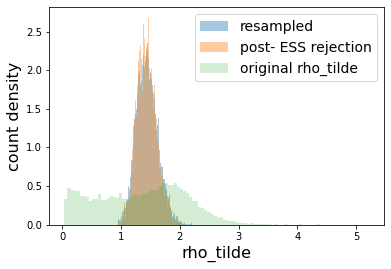

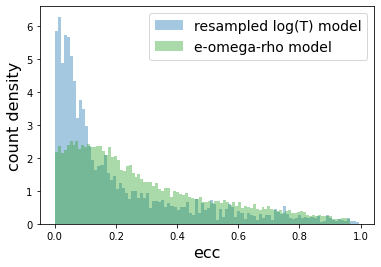

run_num = 18
ESS_mcmc = 3058.932484
ESS_imp = 3015.014268


/Users/mason/miniconda3/envs/mgp22/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [          nan           nan           nan           nan           nan
           nan           nan           nan -742.09123046  -41.83673748
    0.77800371   11.69771166   15.965976     18.05500838   19.26453624
   20.03979445   20.55893726   20.91094897   21.14970601   21.31087334
   21.41868653   21.4896614    21.53498444   21.56217669   21.57628436
   21.58071942   21.57783137   21.56927923   21.55626408   21.53967139
   21.52015898   21.49821422   21.47419458   21.44835854   21.42089047
   21.39192058   21.36154061   21.32981554   21.29679191   21.26250318
   21.22697283   21.19021594   21.15223967   21.11304315   21.07261725
   21.03094437   20.98799839   20.94374499   20.89814219   20.85114116
   20.8026873    20.75272136   20.70118075]
  warnings.warn(


N_kept: 2983


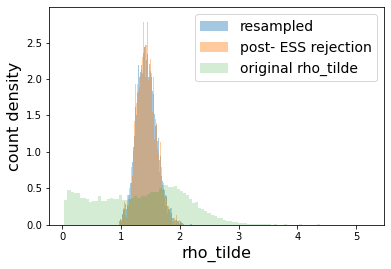

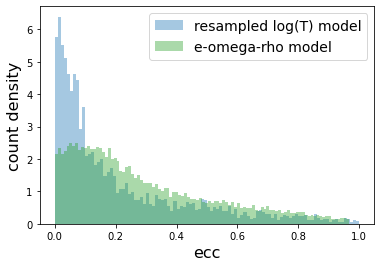

run_num = 19
ESS_mcmc = 3058.932484
ESS_imp = 3000.025064
N_kept: 2975


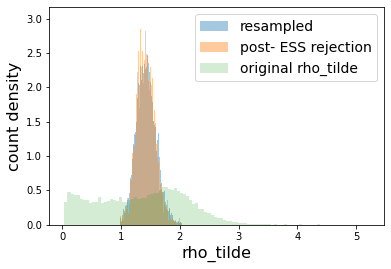

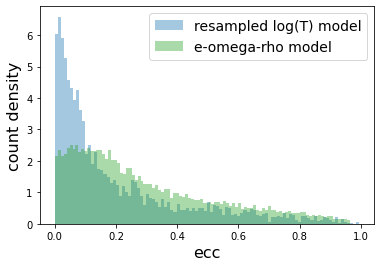

run_num = 20
ESS_mcmc = 3058.932484
ESS_imp = 2965.321564
N_kept: 2919


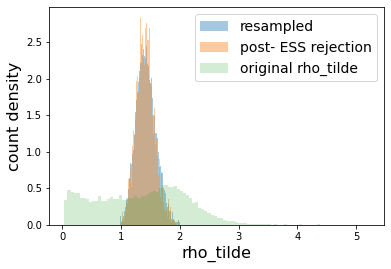

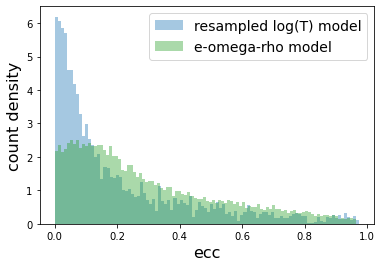

run_num = 21
ESS_mcmc = 3058.932484
ESS_imp = 3012.196425
N_kept: 2984


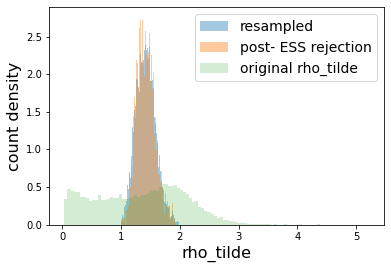

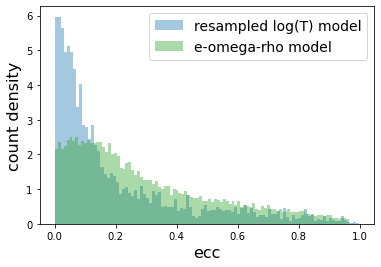

run_num = 22
ESS_mcmc = 3058.932484
ESS_imp = 3016.091136
N_kept: 2990


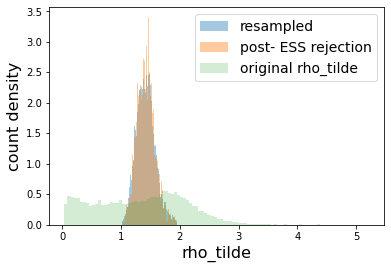

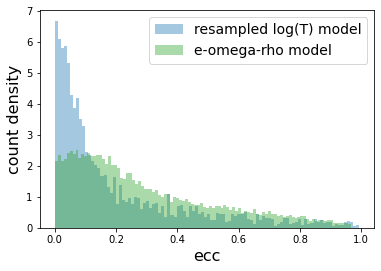

run_num = 23
ESS_mcmc = 3058.932484
ESS_imp = 2994.313722
N_kept: 2978


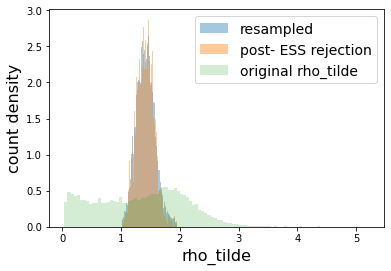

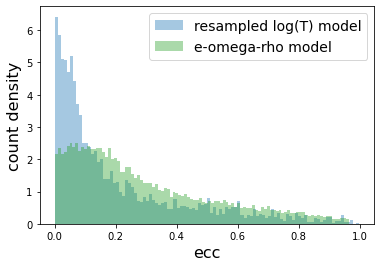

run_num = 24
ESS_mcmc = 3058.932484
ESS_imp = 3031.868645
N_kept: 2958


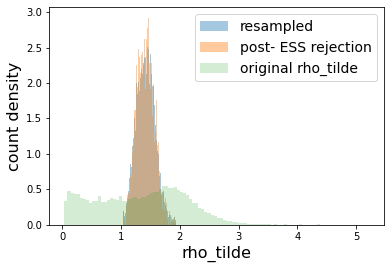

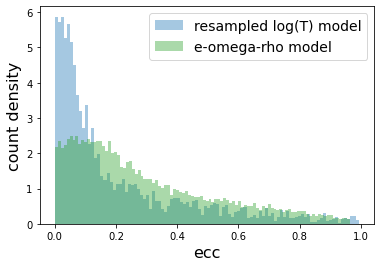

run_num = 25
ESS_mcmc = 3058.932484
ESS_imp = 3059.234324
N_kept: 3015


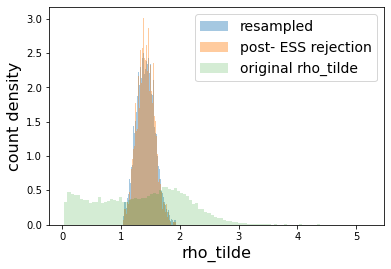

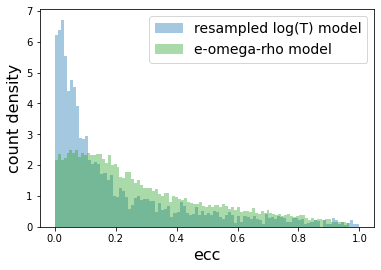

In [5]:
ess_imp = 0
d_ess_lim = 0.1

run_num = 0
run_lim = 60

n_fin = len(data)

while ess_mcmc >= ess_imp:
    run_num += 1
    print('run_num = %d'%(run_num))
    
    # Get bandwidth
    bw = get_bw(samples)
    ###bw_rho = get_bw(samples_rho)
    
    
    # Get new samples with KDE
    samples_new = get_new_samples(samples, bw, n_fin)
    ###samples_new_rho = get_new_samples(samples_rho, bw_rho, n_fin)


    # Use new samples for importance sampling
    weights, ecc, omega = imp_sample(samples_new, RHO_OBS)

    
    # Get effective sample size from importance sampled data
    ess_imp = 1 / np.sum(weights**2)
    print('ESS_mcmc = %f\nESS_imp = %f'%(ess_mcmc, ess_imp))

    
    # Use leave-out-out to measure 'd_ess' for each sample as a measure of sample importance
    X = weights.reshape(-1,1)
    loo = LeaveOneOut()

    ess_tests = []
    for train_index, test_index in loo.split(X):
        ess_tests.append(1 / np.sum(X[train_index].reshape(-1)**2))

    d_ess = np.abs(np.array(np.array(ess_tests) - ess_imp))

    
    # Keep only samples with 'd_ess' above the limit 'd_ess_lim'
    print('N_kept: %d'%(np.sum(d_ess>d_ess_lim)))
    idx_keep = np.arange(len(ess_tests))[d_ess>d_ess_lim]

    samples = samples_new.reshape(-1)[idx_keep].reshape(-1,1)
    ###samples_rho = samples_new_rho.reshape(-1)[idx_keep].reshape(-1,1)
    
    
    # Plot new 'resampled' data vs. 'post- ESS rejection' data vs. 
    # 'original' data from log(T) method results
    plt.figure();
    plt.hist(samples_new, bins=100, density=True, alpha=0.4, label='resampled');
    plt.hist(samples.reshape(-1), bins=100, density=True, alpha=0.4, label='post- ESS rejection');
    plt.hist(data.reshape(-1), bins=100, density=True, alpha=0.2, label='original rho_tilde');
    plt.ylabel('count density', fontsize=16)
    plt.xlabel('rho_tilde', fontsize=16)
    plt.legend(fontsize=14);
    plt.show();
    

    # Plot eccentricity distribution of new data with importance sampling vs. 
    # empirical eccentricity distribution from e-omega-rho sampling
    plt.figure();
    plt.hist(ecc[idx_keep], weights=weights[idx_keep], bins=100, density=True, alpha=0.4, label='resampled log(T) model');
    plt.hist(trace_EW['ecc'], bins=100, density=True, alpha=0.4, label='e-omega-rho model', color='C2');
    plt.ylabel('count density', fontsize=16)
    plt.xlabel('ecc', fontsize=16)
    plt.legend(fontsize=14);
    plt.show();
    

    if run_num >= run_lim:
        print('Run limit (%d runs) exceeded!'%(run_lim))
        break

This just looks like rho_tilde is converging on the true injected value of rho_star... 

Maybe I'm implementing something wrong here?